# Corn Yield Prediction 

Below is is v0 of Kristin's corn yield prediction model (using 3 measurements of SIF and walk forward validation) and steps I followed:

1. Create a baseline linear model using the provided formula and treat it as benchmark. (only at national level)
2. Retrieve Data from Fused UDF-Cornucopia 
3. Implement a Random Forest model for yield prediction (at county level)
4. Perform a walk-forward validation (train/test splits by year).
5. Reserve a final holdout set to measure out-of-sample performance.


## 1. Baseline Model

Baseline model gathered data from this image (https://www.nass.usda.gov/Charts_and_Maps/Field_Crops/cornyld.php) using data previous to 2015 and removing outliers.

In [229]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
    
#test
#Create baseline model based on USDA Screenshot data from 1995
# Data extracted from the chart
years = np.array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014]).reshape(-1, 1)
yields = np.array([113.5, 127.1, 126.7, 134.4, 133.8, 136.9, 138.2, 129.3, 142.2, 160.3, 147.9, 150.7, 153.3, 152.6, 164.4, 146.8, 158.1, 158.1, 171.0])

# Remove outliers
q1, q3 = np.percentile(yields, [25, 75])
iqr = q3 - q1
mask = (yields >= q1 - 1.5 * iqr) & (yields <= q3 + 1.5 * iqr)
years, yields = years[mask], yields[mask]

# Fit and predict
model = LinearRegression().fit(years, yields)
yield_predictions = model.predict(years)

# Predict for 2015-2020
target_years = np.array(range(2015, 2021)).reshape(-1, 1)
predictions = model.predict(target_years)

# Calculate error for the baseline model
baseline_predictions = model.predict(years)
mse = mean_squared_error(yields, baseline_predictions)

# Create a table for predictions
data = {
    "year": range(2015, 2021),
    "Predicted Yield (baseline)": predictions.round(2),
    "Actual Yield (USDA)": [168.4, 174.6, 176.6, 176.4, 167.5, 172.0],  # Hard-coded actual yields
    "USDA June Prediction": [166.8, 168.0, 170.7, 174.0, 176.0, 178.5]  # Hard-coded USDA predictions
}
prediction_table = pd.DataFrame(data)

# Output table
print("\nPredicted Yields (2015-2020):")
print(prediction_table)


# Output model and error
print(f"Linear Model: Yield = {model.coef_[0]:.2f} * Year + {model.intercept_:.2f}")
print(f"Mean Squared Error: {mean_squared_error(yields, yield_predictions):.2f}")






Predicted Yields (2015-2020):
   year  Predicted Yield (baseline)  Actual Yield (USDA)  USDA June Prediction
0  2015                      169.84                168.4                 166.8
1  2016                      172.16                174.6                 168.0
2  2017                      174.49                176.6                 170.7
3  2018                      176.82                176.4                 174.0
4  2019                      179.14                167.5                 176.0
5  2020                      181.47                172.0                 178.5
Linear Model: Yield = 2.33 * Year + -4518.23
Mean Squared Error: 40.42


## 2. Retrieve Data from Fused

### Connect to Fuseda and Use Cornucopia UDF. 

We specify the area for the UDF to download data by passing a GeoDataFrame to the bbox parameter.

In [230]:
# pip install fused -q

In [231]:
# # Run this cell, visit the URL, paste the provided credentials snippet in a new cell
# from fused.api import NotebookCredentials
# credentials = NotebookCredentials()

In [232]:
# credentials.finalize(code="_eLzl1HR2p7rPZ3JsKtqkMcPScc6R--WRYpaJwFyOJbGY")

In [233]:
import fused
import geopandas as gpd
import shapely
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# bbox = gpd.GeoDataFrame(
#     geometry=[shapely.box(-73.9847, 40.7666, -73.9810, 40.7694)], 
#     crs=4326
# )
# bbox


### Run the Cornucopia UDF




In [234]:
df = fused.run('fsh_6zh59m43BXZwFulEbTBux4') 
df.head()


,GEOID,year,corn_sif_mean_05a,corn_sif_mean_05b,corn_sif_mean_06a,corn_sif_mean_06b,corn_sif_mean_07a,corn_sif_mean_07b,bushels_per_acre_actual,m_pct,bushels_sum_actual,geometry,area_county_acres,area_corn_acres
0,08001,2015,0.186108,0.172740,0.192047,0.150622,0.111702,0.115894,112.5,0.030000,2.567807e+06,"POLYGON ((-105.05325 39.79106, -105.05318 39.7...",7.608318e+13,22824.954169
1,08001,2016,0.161535,0.190601,0.195189,0.164982,0.111946,0.109124,90.1,0.041667,2.856289e+06,"POLYGON ((-105.05325 39.79106, -105.05318 39.7...",7.608318e+13,31701.325234
2,08001,2019,0.133727,0.171983,0.172547,0.150526,0.107569,0.085904,54.8,0.040000,1.667743e+06,"POLYGON ((-105.05325 39.79106, -105.05318 39.7...",7.608318e+13,30433.272225
3,08001,2020,0.093818,0.110415,0.103081,0.069896,0.054491,0.085923,42.1,0.040000,1.281241e+06,"POLYGON ((-105.05325 39.79106, -105.05318 39.7...",7.608318e+13,30433.272225
4,08003,2016,0.007843,0.164706,0.239216,0.290196,0.466667,0.403922,0.0,0.000000,0.000000e+00,"POLYGON ((-106.03841 37.74835, -106.02912 37.7...",4.666594e+13,0.000000


In [235]:
df['year'].unique()

# Count the number of rows for each unique year
year_counts = df['year'].value_counts().sort_index()

# Display the result
print(year_counts)

year
2015    1320
2016     469
2019    1341
2020    1339
Name: count, dtype: int64


In [236]:
null_counts = df.isnull().sum()
print(null_counts)


GEOID                      0
year                       0
corn_sif_mean_05a          0
corn_sif_mean_05b          0
corn_sif_mean_06a          0
corn_sif_mean_06b          0
corn_sif_mean_07a          0
corn_sif_mean_07b          0
bushels_per_acre_actual    0
m_pct                      0
bushels_sum_actual         0
geometry                   0
area_county_acres          0
area_corn_acres            0
dtype: int64


In [237]:
print(df.describe())

              year  corn_sif_mean_05a  corn_sif_mean_05b  corn_sif_mean_06a  \
count  4469.000000        4469.000000        4469.000000        4469.000000   
mean   2017.803312           0.209363           0.270496           0.338732   
std       2.130485           0.134497           0.143878           0.131870   
min    2015.000000           0.003922           0.007843           0.015686   
25%    2015.000000           0.103733           0.156422           0.231988   
50%    2019.000000           0.170455           0.241020           0.318503   
75%    2020.000000           0.293452           0.363870           0.435630   
max    2020.000000           0.960784           0.823529           0.811765   

       corn_sif_mean_06b  corn_sif_mean_07a  corn_sif_mean_07b  \
count        4469.000000        4469.000000        4469.000000   
mean            0.402625           0.478578           0.528044   
std             0.135802           0.139933           0.165133   
min             0.028156

### Year by Year Walk Forward


### Predict Bushels per Acre

      year  geoid  actual  predicted
0     2016  08001    90.1     46.377
1     2016  08003     0.0      2.588
2     2016  08005     0.0     80.685
3     2016  08009   128.2     56.471
4     2016  08011   155.4     39.101
...    ...    ...     ...        ...
3144  2020  55133   166.2    152.229
3145  2020  55135   159.4    147.293
3146  2020  55137   151.8    152.029
3147  2020  55139   149.9    147.239
3148  2020  55141   160.9    148.413

[3149 rows x 4 columns]
   year      actual  model1_pred
0  2016  132.541365   121.739064
1  2019   99.165921   108.457261
2  2020  135.759074   112.288446
Feature Importances:
                  Feature  Importance
8                   m_pct    0.389233
2       corn_sif_mean_06a    0.112932
6         area_corn_acres    0.109035
7       area_county_acres    0.086951
3  rate_of_change_05a_05b    0.079108
5  rate_of_change_05a_06a    0.070602
4  rate_of_change_05b_06a    0.062936
0       corn_sif_mean_05b    0.045660
1       corn_sif_mean_05b    0.04354

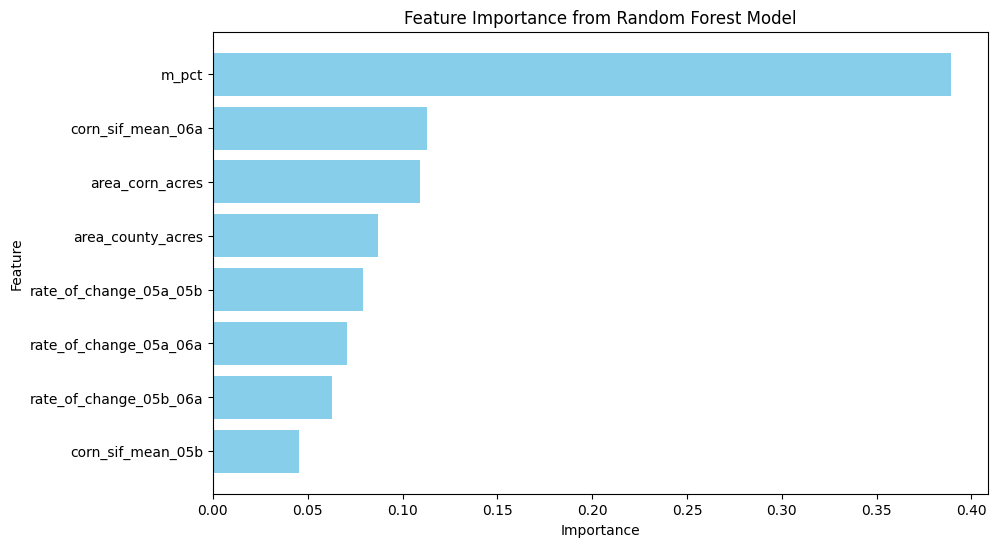

In [238]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Sort your data by year
df = df.sort_values(['year', 'GEOID']).reset_index(drop=True)

# Create rate of change features
df['rate_of_change_05a_05b'] = (df['corn_sif_mean_05b'] - df['corn_sif_mean_05a']) / df['corn_sif_mean_05a']
df['rate_of_change_05b_06a'] = (df['corn_sif_mean_06a'] - df['corn_sif_mean_05b']) / df['corn_sif_mean_05b']
# df['rate_of_change_06a_06b'] = (df['corn_sif_mean_06b'] - df['corn_sif_mean_06a']) / df['corn_sif_mean_06a']
df['rate_of_change_05a_06a'] = (df['corn_sif_mean_06a'] - df['corn_sif_mean_05a']) / df['corn_sif_mean_05a']

# Define predictive features and target
features = ['corn_sif_mean_05b','corn_sif_mean_05b', 'corn_sif_mean_06a','rate_of_change_05a_05b',
            'rate_of_change_05b_06a', 'rate_of_change_05a_06a',
            'area_corn_acres', 'area_county_acres','m_pct']
target = 'bushels_per_acre_actual'

# List unique years in ascending order
all_years = sorted(df['year'].unique())

model1 = []

# Walk-forward loop, year-by-year
for test_year in all_years[1:]:
    # Training and testing data
    train_data = df[df['year'] < test_year]
    test_data = df[df['year'] == test_year]
    
    if train_data.empty or test_data.empty:
        continue

    # Define X and y
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]

    # Fit the Random Forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf.predict(X_test)

    # Store actual vs. predicted results along with GEOID
    for actual, predicted, geoid in zip(y_test, y_pred, test_data['GEOID']):
        model1.append({
            'year': test_year,
            'geoid': geoid,
            'actual': actual,
            'predicted': predicted
        })

# Convert to DataFrame
# Convert to DataFrame
model1_avg = pd.DataFrame(model1)
print(model1_avg)
# Average results by year
model1_avg = model1_avg.groupby('year').agg({
    'actual': 'mean',
    'predicted': 'mean',
}).reset_index()

model1_avg.rename(columns={'predicted': 'model1_pred'}, inplace=True)

# # Create a DataFrame with total area_corn_acres summed across all years
# total_area_corn_acres_by_year = df.groupby('year')['area_corn_acres'].mean().reset_index()

# # Add 'area_corn_acres' from the test_year to 'bushels_average' and calculate new columns
# model1_avg = model1_avg.merge(
#     total_area_corn_acres_by_year, 
#     on='year', 
#     how='left'
# )

# model1_avg['actual_bushels'] = model1_avg['actual'] / model1_avg['area_corn_acres']
# model1_avg['predicted_bushels'] = model1_avg['predicted'] / model1_avg['area_corn_acres']

# print(model1_avg.head())

print(model1_avg)

# Feature importance
rf.fit(df[features], df[target])
feature_importances = pd.DataFrame({'Feature': features, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest Model')
plt.gca().invert_yaxis()
plt.show()


###Predict total Bushels

   year        actual     predicted  area_corn_acres  actual_bushels  \
0  2016  1.397894e+07  1.279883e+07     81940.551544      170.598608   
1  2019  8.161622e+06  9.157731e+06     60269.661892      135.418420   
2  2020  1.051929e+07  9.669527e+06     62901.637713      167.233885   

   model2_pred  
0   156.196537  
1   151.945948  
2   153.724560  
   year        actual     predicted  area_corn_acres  actual_bushels  \
0  2016  1.397894e+07  1.279883e+07     81940.551544      170.598608   
1  2019  8.161622e+06  9.157731e+06     60269.661892      135.418420   
2  2020  1.051929e+07  9.669527e+06     62901.637713      167.233885   

   model2_pred  
0   156.196537  
1   151.945948  
2   153.724560  
Feature Importances:
                  Feature  Importance
6         area_corn_acres    0.880669
8                   m_pct    0.036171
2       corn_sif_mean_06a    0.020745
4  rate_of_change_05b_06a    0.013567
5  rate_of_change_05a_06a    0.012638
3  rate_of_change_05a_05b    0.011917

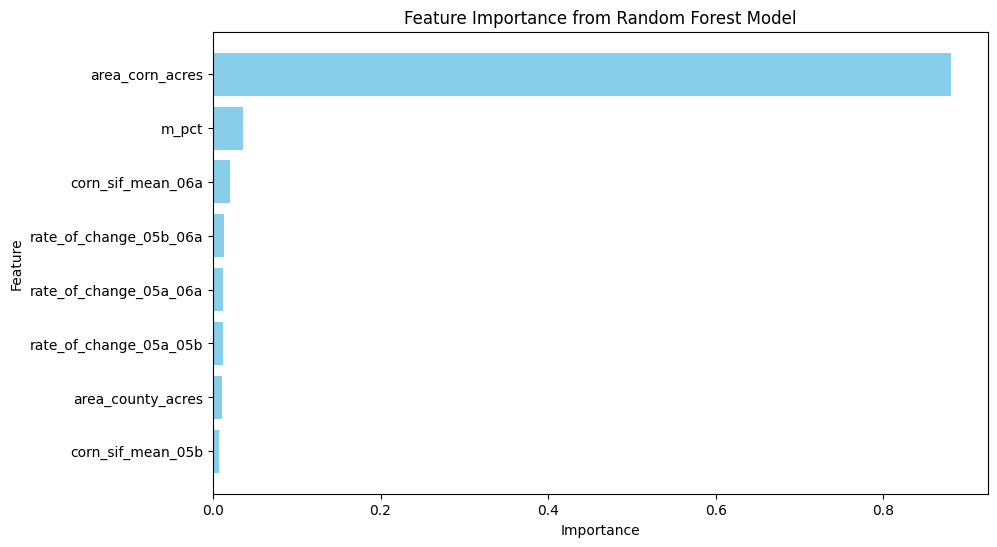

In [239]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Sort your data by year
df = df.sort_values(['year', 'GEOID']).reset_index(drop=True)

# Create rate of change features
df['rate_of_change_05a_05b'] = (df['corn_sif_mean_05b'] - df['corn_sif_mean_05a']) / df['corn_sif_mean_05a']
df['rate_of_change_05b_06a'] = (df['corn_sif_mean_06a'] - df['corn_sif_mean_05b']) / df['corn_sif_mean_05b']
# df['rate_of_change_06a_06b'] = (df['corn_sif_mean_06b'] - df['corn_sif_mean_06a']) / df['corn_sif_mean_06a']
df['rate_of_change_05a_06a'] = (df['corn_sif_mean_06a'] - df['corn_sif_mean_05a']) / df['corn_sif_mean_05a']

# Define predictive features and target
features = ['corn_sif_mean_05b','corn_sif_mean_05b', 'corn_sif_mean_06a','rate_of_change_05a_05b',
            'rate_of_change_05b_06a', 'rate_of_change_05a_06a',
            'area_corn_acres', 'area_county_acres','m_pct']
target = 'bushels_sum_actual'

# List unique years in ascending order
# all_years = sorted(df['year'].unique())

# Prepare data structure to save actual vs. predicted results
actual_vs_predicted = []

# Walk-forward loop, year-by-year
for test_year in all_years[1:]:
    # Training and testing data
    train_data = df[df['year'] < test_year]
    test_data = df[df['year'] == test_year]
    
    if train_data.empty or test_data.empty:
        continue

    # Define X and y
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]

    # Fit the Random Forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf.predict(X_test)

    # Store actual vs. predicted results
    for actual, predicted in zip(y_test, y_pred):
        actual_vs_predicted.append({
            'year': test_year,
            'actual': actual,
            'predicted': predicted
        })

# Convert to DataFrame
actual_vs_predicted_df = pd.DataFrame(actual_vs_predicted)

# Average results by year
bushels_average = actual_vs_predicted_df.groupby('year').agg({
    'actual': 'mean',
    'predicted': 'mean',
}).reset_index()


# Create a DataFrame with total area_corn_acres summed across all years
total_area_corn_acres_by_year = df.groupby('year')['area_corn_acres'].mean().reset_index()

# Add 'area_corn_acres' from the test_year to 'bushels_average' and calculate new columns
bushels_average = bushels_average.merge(
    total_area_corn_acres_by_year, 
    on='year', 
    how='left'
)

bushels_average['actual_bushels'] = bushels_average['actual'] / bushels_average['area_corn_acres']
bushels_average['model2_pred'] = bushels_average['predicted'] / bushels_average['area_corn_acres']

print(bushels_average.head())

print(bushels_average)

# Feature importance
rf.fit(df[features], df[target])
feature_importances = pd.DataFrame({'Feature': features, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest Model')
plt.gca().invert_yaxis()
plt.show()


In [240]:
import pandas as pd

# Selecting only the required columns and renaming them before merging
model1_avg_trimmed = model1_avg[['year', 'model1_pred']].rename(columns={'model1_pred': 'pred_bu_acre'})
bushels_average_trimmed = bushels_average[['year', 'model2_pred']].rename(columns={'model2_pred': 'pred_bu'})

# Merging 'model1_pred' from model1_avg_trimmed into prediction_table on 'year'
prediction_table = prediction_table.merge(
    model1_avg_trimmed,
    on='year',
    how='left'
)

# Merging 'model2_pred' from bushels_average_trimmed into prediction_table on 'year'
prediction_table = prediction_table.merge(
    bushels_average_trimmed,
    on='year',
    how='left'
)

# Display the updated prediction_table
prediction_table.head()

,year,Predicted Yield (baseline),Actual Yield (USDA),USDA June Prediction,pred_bu_acre,pred_bu
0,2015,169.84,168.4,166.8,NaN,NaN
1,2016,172.16,174.6,168.0,121.739064,156.196537
2,2017,174.49,176.6,170.7,NaN,NaN
3,2018,176.82,176.4,174.0,NaN,NaN
4,2019,179.14,167.5,176.0,108.457261,151.945948
